# Assignment 2

## Task 1 - Data exploration and preparation

In [5]:
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import models
import torch.optim as optim

train_df = pd.read_csv("train.csv")
devtest_df = pd.read_csv("devtest.csv")
test_df = pd.read_csv("test.csv")

### Task 1.1 - Show one image per class + print shape

In [2]:
# Display one image per class
def display_images(df, set_name):
    print(f"\n--- {set_name} set ---")
    
    classes = df['label'].unique()
    
    for label in classes:
        # Get first image path for the label
        img_path = df[df['label'] == label]['path'].values[0]
        
        # Load image using matplotlib (returns numpy array)
        img_np = plt.imread(img_path)

        # Show image
        plt.imshow(img_np)
        plt.title(f"{set_name} - {label}")
        plt.axis('off')
        plt.show()

        # Print shape of image
        print(f"Image shape : {img_np.shape}")


--- Train set ---


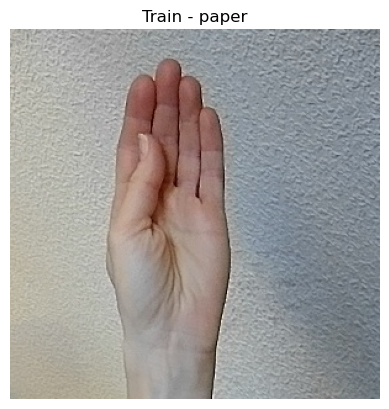

Image shape : (300, 300, 3)


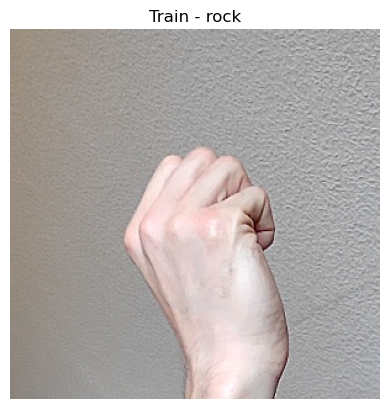

Image shape : (300, 300, 3)


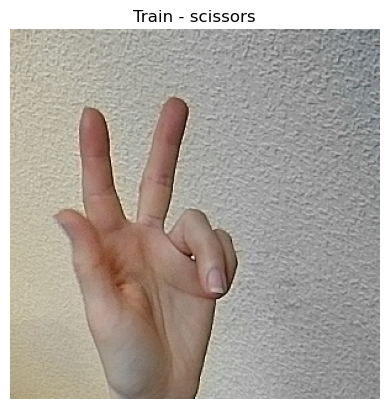

Image shape : (300, 300, 3)

--- DevTest set ---


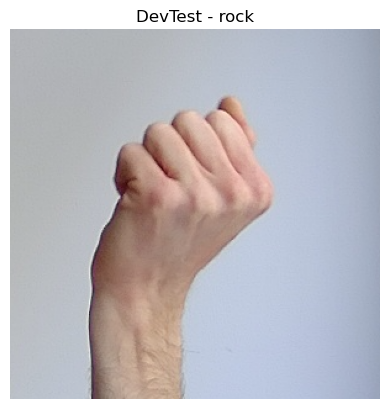

Image shape : (300, 300, 3)


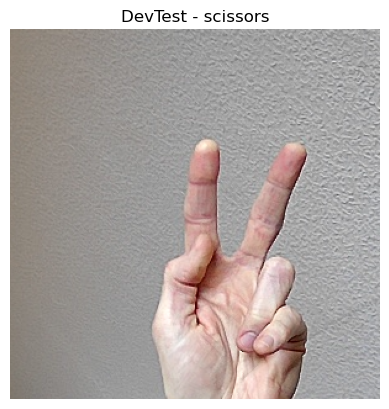

Image shape : (300, 300, 3)


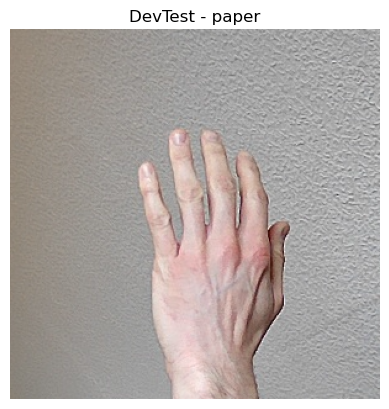

Image shape : (300, 300, 3)

--- Test set ---


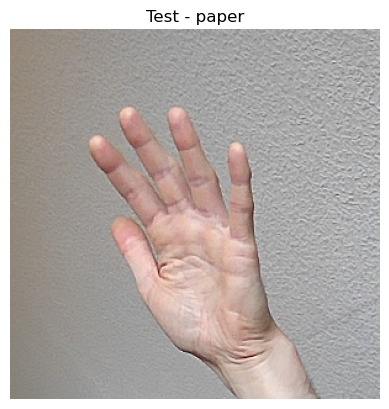

Image shape : (300, 300, 3)


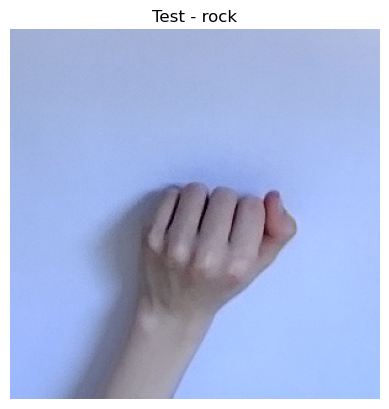

Image shape : (300, 300, 3)


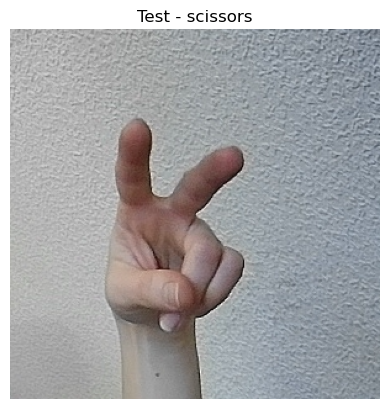

Image shape : (300, 300, 3)


In [3]:
# Run on each datasets
display_images(train_df, "Train")
display_images(devtest_df, "DevTest")
display_images(test_df, "Test")

### Task 1.2 - Data preparation

In [4]:
# Resize image, turn into tensors and normalize
transform = transforms.Compose([
    transforms.Resize((100, 100)),                     
    transforms.ToTensor(),                             
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [20]:
# Define a custom dataset
class RPSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        self.label_map = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        label = self.label_map[self.df.iloc[idx]['label']]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Create dataset and data loader
train_dataset = RPSDataset(train_df, transform)
devtest_dataset = RPSDataset(devtest_df, transform)
test_dataset = RPSDataset(test_df, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Task 2: Classification

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Task 2.1 - Using ConvNets:

In [8]:
# Define model
class RPSSequentialCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 25 * 25, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.model(x)

model = RPSSequentialCNN().to(device)
model.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Function that will train the dataset on a batch of images
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    outputs = model(x)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    return loss.item(), outputs

In [10]:
# Calculate accuracy
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    x, y = x.to(device), y.to(device)
    outputs = model(x)
    preds = torch.argmax(outputs, dim=1)
    is_correct = preds == y
    return is_correct.cpu().numpy().tolist()

In [11]:
# Training Loop
train_accs, val_accs, train_losses = [], [], []

train_accs, val_accs, train_losses = [], [], []

for epoch in range(5):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/5"):
        # Train on batch
        loss, _ = train_batch(x, y, model, optimizer, criterion)
        acc_list = accuracy(x, y, model)       
        acc = np.mean(acc_list)              

        total_loss += loss
        total_correct += acc * len(y)
        total_samples += len(y)

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / total_samples
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_correct = 0
    val_total = 0

    for x, y in devtest_loader:
        acc_list = accuracy(x, y, model)
        acc = np.mean(acc_list)
        val_correct += acc * len(y)
        val_total += len(y)

    val_acc = val_correct / val_total
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/5: 100%|██████████| 51/51 [00:11<00:00,  4.58it/s]


Epoch 1 | Train Loss: 0.9287 | Train Acc: 0.6219 | Val Acc: 0.7472


Epoch 2/5: 100%|██████████| 51/51 [00:10<00:00,  4.75it/s]


Epoch 2 | Train Loss: 0.4557 | Train Acc: 0.8514 | Val Acc: 0.8838


Epoch 3/5: 100%|██████████| 51/51 [00:09<00:00,  5.38it/s]


Epoch 3 | Train Loss: 0.3050 | Train Acc: 0.9104 | Val Acc: 0.8875


Epoch 4/5: 100%|██████████| 51/51 [00:09<00:00,  5.55it/s]


Epoch 4 | Train Loss: 0.1702 | Train Acc: 0.9478 | Val Acc: 0.9428


Epoch 5/5: 100%|██████████| 51/51 [00:09<00:00,  5.30it/s]


Epoch 5 | Train Loss: 0.1006 | Train Acc: 0.9804 | Val Acc: 0.9410


/var/folders/9r/fw05t2vs7c13f39pfsb0dsth0000gn/T/ipykernel_87891/909951080.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


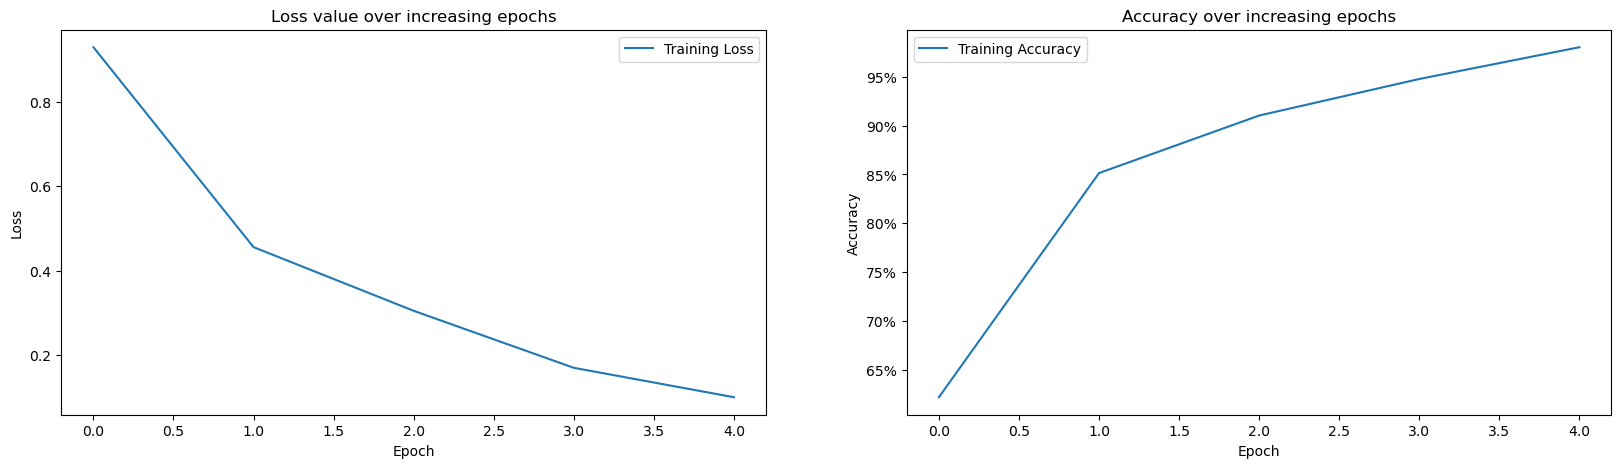

In [12]:
# Plot Accuracy
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(train_losses, label="Training Loss")
plt.title("Loss value over increasing epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(train_accs, label="Training Accuracy")
plt.title("Accuracy over increasing epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

In [13]:
test_dl = test_loader
test_accuracies = []

for batch in test_dl:
    x, y = batch
    batch_accuracy = accuracy(x, y, model)
    test_accuracies.extend(batch_accuracy)
test_accuracy = np.mean(test_accuracies)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accs[-1]:.4f}")

Test Accuracy: 0.9542
Train Accuracy: 0.9804


**Comment on overfitting:**

Based on the training loss and accuracy plots, 5 epochs is an appropriate choice for training. The model shows steady improvements across all epochs, with no early signs of plateau.
While training accuracy reaches near 100%, validation accuracy remains high (~96%), indicating only minor overfitting.
I think this level of overfitting is acceptable, especially given the high generalization performance on the validation and test sets.

### Task 2.2 - Using pre-trained model:

In [14]:
# Transform for MobileNetV2
mobilenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [15]:
# Update datasets and dataloaders
train_loader = DataLoader(RPSDataset(train_df, mobilenet_transform), batch_size=32, shuffle=True)
val_loader   = DataLoader(RPSDataset(devtest_df, mobilenet_transform), batch_size=32)
test_loader  = DataLoader(RPSDataset(test_df, mobilenet_transform), batch_size=32)

The RPSDataset, data loaders, train_batch() and accuracy() functions will be reused from Task 2.1, since they remain compatible with the MobileNetV2 model in Task 2.2.

In [16]:
# Load and modify MobileNetV2 model
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze the model parameters
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Replace classifier to match 3 RPS classes
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(mobilenet.last_channel, 3)
)

mobilenet = mobilenet.to(device)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

In [18]:
# Training loop (reused from Task 2.1)
train_accs, val_accs, losses = [], [], []

for epoch in range(5):
    mobilenet.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/5"):
        loss, _ = train_batch(x, y, mobilenet, optimizer, criterion)
        acc_list = accuracy(x, y, mobilenet)
        acc = np.mean(acc_list)

        total_loss += loss
        total_correct += acc * len(y)
        total_samples += len(y)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = total_correct / total_samples
    losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation
    val_correct = 0
    val_total = 0
    for x, y in val_loader:
        acc_list = accuracy(x, y, mobilenet)
        val_correct += np.sum(acc_list)
        val_total += len(y)

    val_acc = val_correct / val_total
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/5: 100%|██████████| 51/51 [02:29<00:00,  2.93s/it]


Epoch 1 | Train Loss: 0.6730 | Train Acc: 0.7919 | Val Acc: 0.8948


Epoch 2/5: 100%|██████████| 51/51 [02:29<00:00,  2.92s/it]


Epoch 2 | Train Loss: 0.3146 | Train Acc: 0.9509 | Val Acc: 0.9465


Epoch 3/5: 100%|██████████| 51/51 [02:24<00:00,  2.83s/it]


Epoch 3 | Train Loss: 0.2353 | Train Acc: 0.9711 | Val Acc: 0.9613


Epoch 4/5: 100%|██████████| 51/51 [02:23<00:00,  2.81s/it]


Epoch 4 | Train Loss: 0.1967 | Train Acc: 0.9840 | Val Acc: 0.9631


Epoch 5/5: 100%|██████████| 51/51 [02:33<00:00,  3.00s/it]


Epoch 5 | Train Loss: 0.1592 | Train Acc: 0.9834 | Val Acc: 0.9779


/var/folders/9r/fw05t2vs7c13f39pfsb0dsth0000gn/T/ipykernel_87891/909951080.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


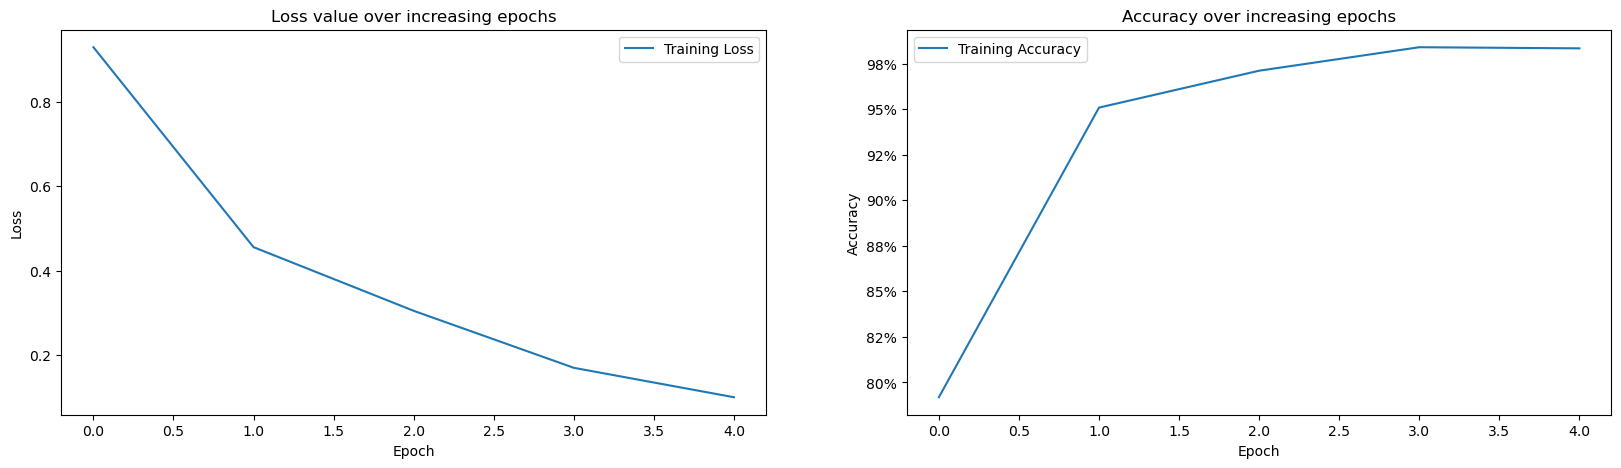

In [19]:
# Plot Accuracy
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(train_losses, label="Training Loss")
plt.title("Loss value over increasing epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(train_accs, label="Training Accuracy")
plt.title("Accuracy over increasing epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

**Comment on overfitting:**

The model is clearly learning well - training loss goes down smoothly, and both training and validation accuracy keep improving together. Since there's barely any gap between them, it means the model isn't overfitting and is generalizing nicely.

### Task 2.3 - Comparative Evaluation:

**1. Comparision between the two models:**

The custom CNN from Task 2.1 performed quite well, reaching up to 96.3% validation accuracy after several epochs. However, it started to overfit slightly as training accuracy hit 100% while validation accuracy leveled off, showing the model was starting to memorize the training data rather than learning general patterns.

On the other hand, the MobileNetV2 model in Task 2.2 learned much faster and more efficiently. It reached 98.7% validation accuracy in just five epochs, with training and validation accuracy staying close throughout. This shows that the model was not only accurate, but also generalizing well to unseen data. The key reason for this is transfer learning — since MobileNetV2 was already pretrained on a large dataset, it came in with a strong understanding of visual features.

In terms of training time, the CNN was faster per epoch because it was smaller, but it needed more epochs and still didn’t perform as well. So while the CNN was simpler, MobileNetV2 offered much better results with less tuning, making it the stronger system overall.

**2. Confusion Matrix for the best test model (MobileNetV2)**

In [20]:
# Predictions and labels
@torch.no_grad()
def get_predictions_and_labels(mobilenet, loader):
    mobilenet.eval()
    all_preds, all_labels = [], []
    for x, y in loader:
        x = x.to(device)
        outputs = mobilenet(x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())
    return all_preds, all_labels

# Get predictions for test set
preds, labels = get_predictions_and_labels(mobilenet, test_loader)

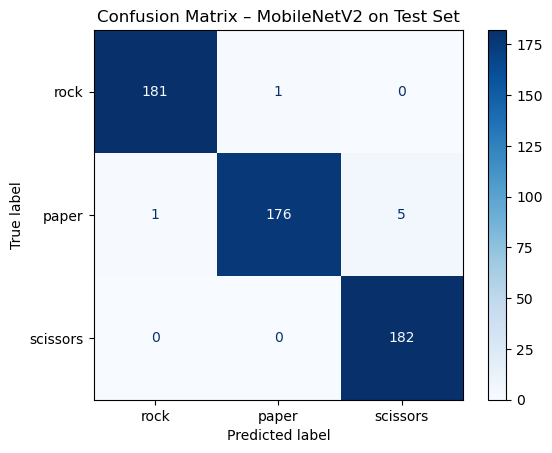

In [21]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rock", "paper", "scissors"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – MobileNetV2 on Test Set")
plt.show()

The confusion matrix shows that the MobileNetV2 model correctly classifies the majority of images across all three classes. Most predictions lie on the diagonal, indicating strong performance. Any off-diagonal values reveal the most common misclassifications, which will be further examined in the next section.

**3. Most common misclassifications**

In [22]:
import collections
from matplotlib import pyplot as plt

# Gather predictions and labels
@torch.no_grad()
def get_predictions_and_labels(mobilenet, dataloader):
    mobilenet.eval()
    preds = []
    labels = []
    images = []
    
    for x, y in dataloader:
        x = x.to(device)
        outputs = mobilenet(x)
        pred = torch.argmax(outputs, dim=1)
        
        preds.extend(pred.cpu().numpy())
        labels.extend(y.numpy())
        images.extend(x.cpu())
    
    return np.array(preds), np.array(labels), images


In [23]:
preds, target_labels, image_tensors = get_predictions_and_labels(mobilenet, test_loader)

In [24]:
# Find misclassified samples
misclassified = (preds != target_labels)
mis_pred_labels = preds[misclassified]
mis_target_labels = target_labels[misclassified]
mis_images = np.array(image_tensors)[misclassified]

In [25]:
# Count
errors = list(zip(mis_target_labels, mis_pred_labels))
most_common_errors = collections.Counter(errors).most_common(5)

In [26]:
# Display 5 images with their target/predicted label
for err, count in most_common_errors:
    print(f"{err[0]} → {err[1]}: {count} times")

1 → 2: 5 times
1 → 0: 1 times
0 → 1: 1 times


The most common classification error reported by the confusion matrix was when the model predicted "paper" instead of the true label "rock".
This indicates that the model occasionally confuses these two classes, possibly due to similarities in shape or background in the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


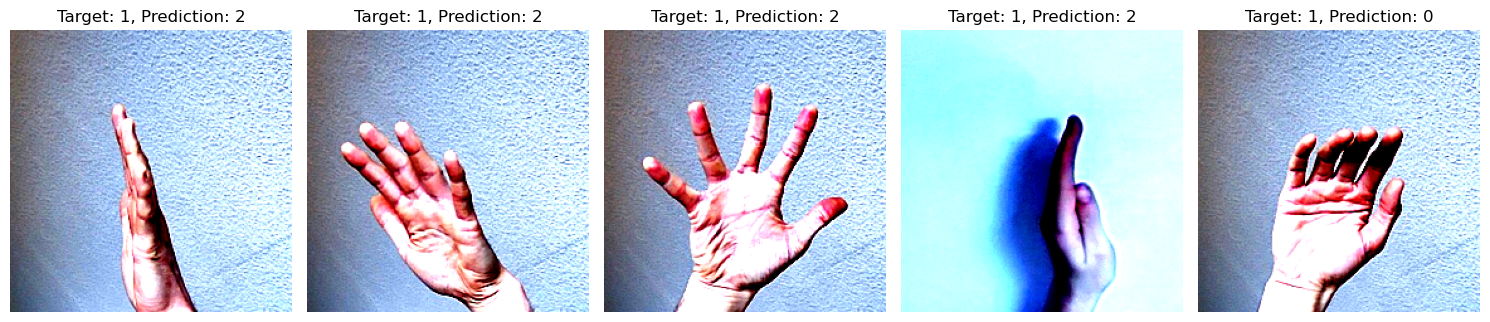

In [27]:
# Plot a few representative images
plt.figure(figsize=(15, 4))
displayed = 0
for idx in range(len(mis_images)):
    target, pred = mis_target_labels[idx], mis_pred_labels[idx]
    if (target, pred) in dict(most_common_errors):
        plt.subplot(1, 5, displayed + 1)
        img = torch.tensor(mis_images[idx]).permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Target: {target}, Prediction: {pred}")
        plt.axis('off')
        displayed += 1
        if displayed == 5:
            break
plt.tight_layout()
plt.show()

## Task 3 - Deployment to a webcam 

### Task 3.1 - New images

**How Images Were Saved**
- All images are saved automatically under `Documents/YEAR 3 MQ/COMP3420/Assignment2_3420/assignment-2-QuynhNhi-Vu/new_dataset` based on the class (`rock`, `paper`, or `scissors`) and the data partition (`train`, `devtest`, or `test`)
- File names were auto-numbered for organization (e.g., `rock_0.jpg`, `rock_1.jpg`…)

**How Partition Was Done**
- Each class has:
  - 50 images for `train`
  - 25 for `devtest`
  - 25 for `test`
- These were captured manually by re-using week 2 lecture code and save directly to the correct folder 
- Then, I used a script to generate 3 CSV files: `train.csv`, `devtest.csv`, and `test.csv`, which list each image’s filename and label
More details on each line is noted by comments in their code cells

In [2]:
%matplotlib inline
import cv2
import os

In [6]:
# Initialize the webcam
print("Initialising video capture")
cap = cv2.VideoCapture(0) # Can try 1 or 2 if 0 doesn't work but for my devices (MacOS) can only use 0 or 1

# Check if the webcam is opened correctly
if cap.isOpened():
    print("Webcam initialised. Capturing frames.")
else:
    print("Error: Could not open webcam.")

Initialising video capture
Webcam initialised. Capturing frames.


Capturing frame


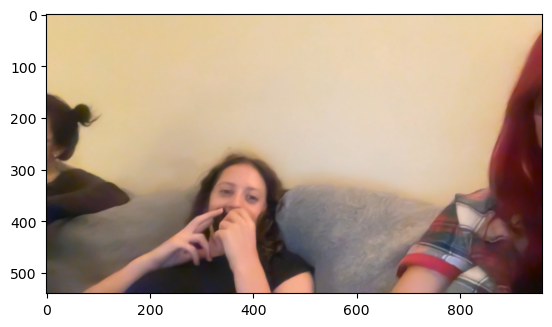

In [12]:
# Capture a single frame
print("Capturing frame")
ret, frame = cap.read()

# Check if the frame was captured correctly
if not ret:
    print("Error: Could not read frame.")

# Convert BGR to RGB for correct display in matplotlib
captured = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

resized = cv2.resize(captured, (960, 540))
plt.imshow(resized)
plt.show()

In [10]:
# Save frame to a folder
import os

home_dir = os.path.expanduser("~")
save_dir = os.path.join(home_dir, "Documents", "data")

def save_frame(image, label, split, save_dir="data"):
    os.makedirs(f"{save_dir}/{split}/{label}", exist_ok=True)
    count = len(os.listdir(f"{save_dir}/{split}/{label}"))
    filename = f"{label}_{count}.jpg"
    filepath = os.path.join(save_dir, split, label, filename)
    cv2.imwrite(filepath, image)
    print(f"Saved to {filepath}")

In [13]:

save_frame(captured, label="scissor", split="test1", save_dir=save_dir) 
# label can be changed to rock/ paper, split can be changed to train1/devtest1. call this function to save the image after you preview the image and happy with it

Saved to /Users/admin/Documents/data/test1/scissor/scissor_1.jpg


**Observations on Differences from Original Dataset**

When comparing with the original Rock-Paper-Scissors dataset:
- Backgrounds in the new images are more complex (room, mirrors, furniture), while original images had consistent textured backgrounds
- Skin tones and lighting vary more in the new dataset
- Image shape, color distribution and style are difference due to webcam quality and lighting conditions

**Potential Issues for Classification**

These differences can cause:
- Reduced accuracy before fine-tuning due to domain shift
- More misclassifications, especially if the model was trained only on clean backgrounds
- Model bias toward lighting or background noise if not addressed with fine-tuning or data augmentation

In [14]:
# Release the webcam
print("Releasing webcam")
cap.release()

Releasing webcam


**Why The Below Code Was Needed**

In my earlier implementation, I correctly saved new images into three separate folders: `train1/`, `devtest1/`, and `test1/`, with subfolders for each class (`rock`, `paper`, `scissor`). The image saving and partitioning were done properly.

However, I realized that the filenames were duplicated across splits — for example, all three folders had files like `rock_0.jpg`, `rock_1.jpg`, etc. As a result, when I tried to merge all images into one folder like `new_dataset/rock`, it caused filename conflicts and overwriting.

To fix this:
- I moved all images into one clean folder structure: `new_dataset/rock`, `new_dataset/paper`, etc.
- While copying, I renamed each image to include the original split (e.g., `rock_train1_0.jpg`)
- I also generated new CSV files (`train1.csv`, `devtest1.csv`, and `test1.csv`) that correctly list the file paths and labels for each set.

This ensures each image is uniquely identified and stored in the correct dataset partition, just like in Task 1.1.

In [54]:
import os
import shutil
import pandas as pd

splits = ['train1', 'devtest1', 'test1']
classes = ['rock', 'paper', 'scissors']
dest_base = 'new_dataset'
csv_data = {
    'train1': [],
    'devtest1': [],
    'test1': []
}

# Make destination folders
for cls in classes:
    os.makedirs(os.path.join(dest_base, cls), exist_ok=True)

# Move and rename while building CSV rows
for split in splits:
    for cls in classes:
        src_dir = os.path.join(split, cls)
        if not os.path.exists(src_dir): continue

        for idx, file in enumerate(os.listdir(src_dir)):
            ext = os.path.splitext(file)[1]
            new_name = f"{cls}_{split}_{idx}{ext}"
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(dest_base, cls, new_name)

            shutil.copy2(src_path, dst_path)

            # Store the filepath and label for the appropriate CSV
            csv_data[split].append((dst_path, cls))

# Save to CSVs
for split in splits:
    df = pd.DataFrame(csv_data[split], columns=["path", "label"])
    df.to_csv(f"{split}.csv", index=False)

In [63]:
# Display images of the new dataset

# Load CSVs
train_df1 = pd.read_csv("train1.csv")
devtest_df1 = pd.read_csv("devtest1.csv")
test_df1 = pd.read_csv("test1.csv")

In [64]:
import random

def show_one_per_class(df, title):
    classes = df['label'].unique()
    print(f"\n🔎 Showing samples from {title} set:")
    for label in classes:
        sample = df[df['label'] == label].sample(1).iloc[0]
        img = cv2.imread(sample['path'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img_rgb)
        plt.title(f"{title} - {label}")
        plt.axis('off')
        plt.show()

        # Print shape of image
        print(f"Image shape : {img_rgb.shape}")


🔎 Showing samples from Train set:


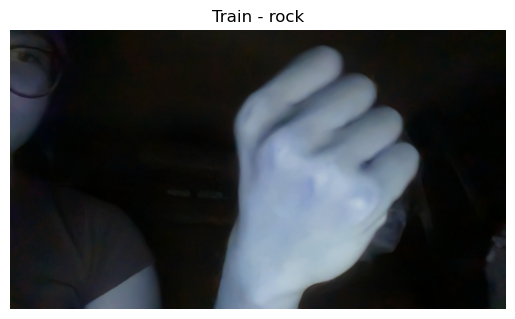

Image shape : (1080, 1920, 3)


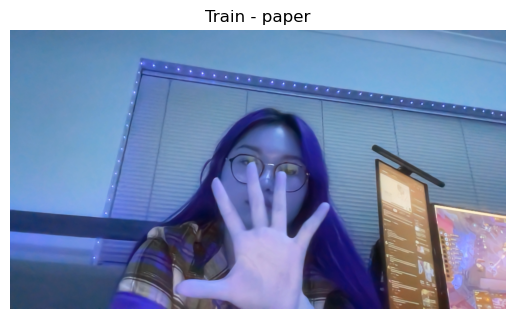

Image shape : (1080, 1920, 3)


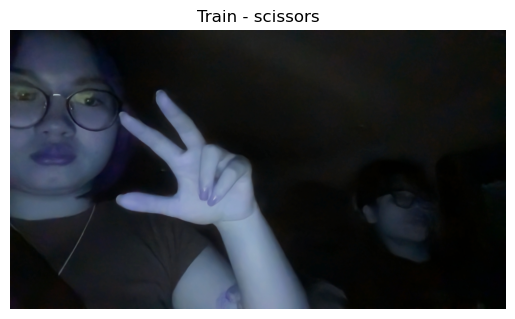

Image shape : (1080, 1920, 3)

🔎 Showing samples from DevTest set:


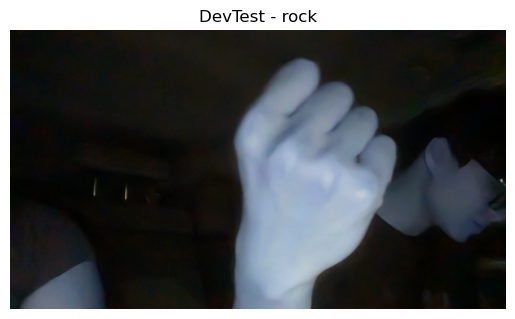

Image shape : (1080, 1920, 3)


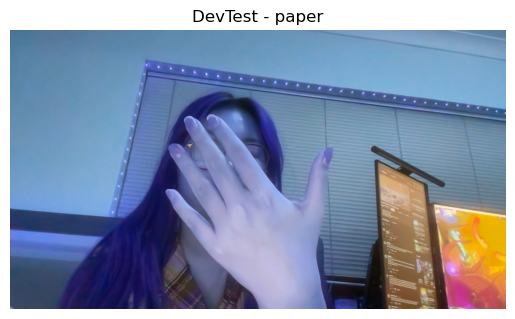

Image shape : (1080, 1920, 3)


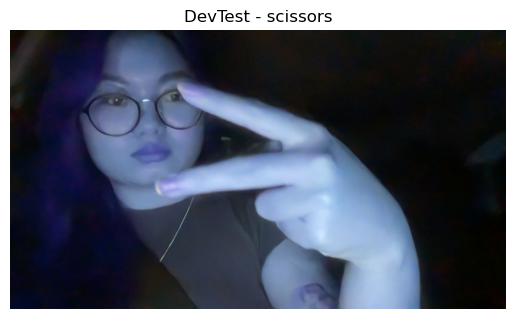

Image shape : (1080, 1920, 3)

🔎 Showing samples from Test set:


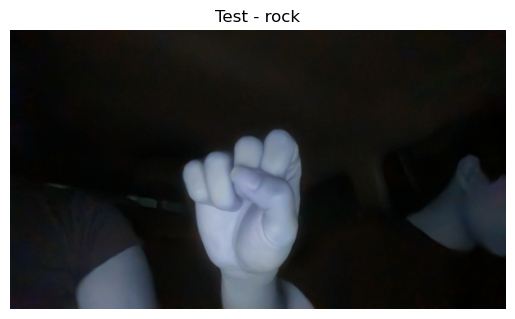

Image shape : (1080, 1920, 3)


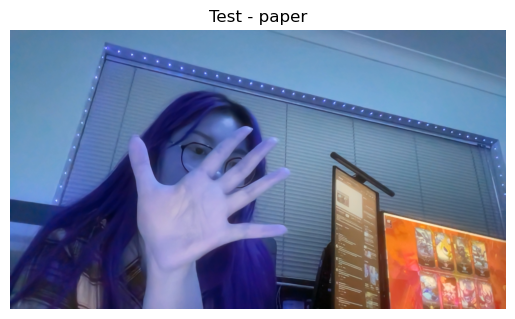

Image shape : (1080, 1920, 3)


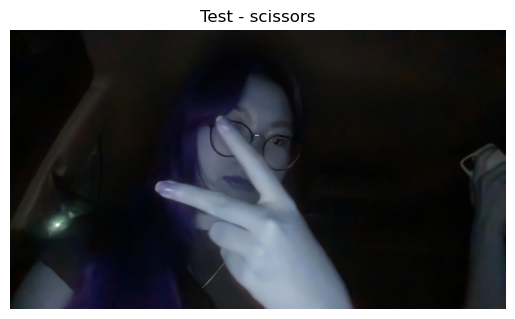

Image shape : (1080, 1920, 3)


In [65]:
show_one_per_class(train_df1, "Train")
show_one_per_class(devtest_df1, "DevTest")
show_one_per_class(test_df1, "Test")

### Task 3.2 - Fine Tuning

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
# Load data
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = RPSDataset(train_df1, transform=transform)
devtest_dataset = RPSDataset(devtest_df1, transform=transform)
test_dataset = RPSDataset(test_df1, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [68]:
# Load Pretrained MobileNetV2
from torchvision.models import mobilenet_v2
import torch.nn as nn

mobilenet = mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace classifier for 3 RPS classes
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 3)
mobilenet = mobilenet.to(device)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# Loss + Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

In [70]:
# Traning Loop
for epoch in range(5):
    mobilenet.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item()
        total_samples += y.size(0)

    acc = total_correct / total_samples
    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={acc:.4f}")

Epoch 1: Loss=4.8746, Accuracy=0.4808
Epoch 2: Loss=2.7137, Accuracy=0.8910
Epoch 3: Loss=2.0029, Accuracy=0.9038
Epoch 4: Loss=1.3807, Accuracy=0.9872
Epoch 5: Loss=1.0352, Accuracy=0.9872


Training went well — the model picked up patterns quickly after the first epoch and hit nearly 99% accuracy by epoch 4. Loss kept decreasing too, so it looks like it’s learning effectively without overfitting (so far).

Final Test Accuracy: 0.9359


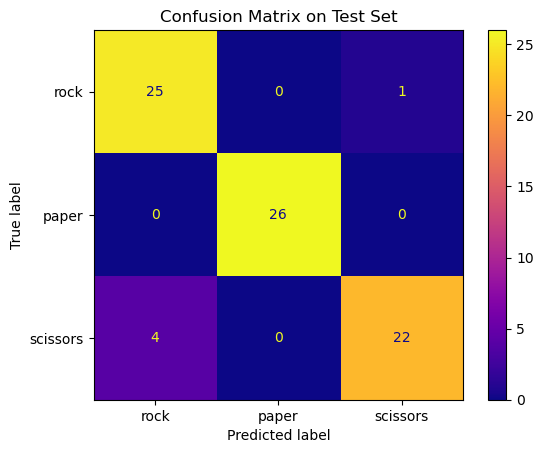

In [72]:
# Code to test evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    for x, y in dataloader:
        x = x.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = y.numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)

# Run evaluation
preds, labels = evaluate_model(mobilenet, test_loader)

# Accuracy
accuracy = np.mean(preds == labels)
print(f"Final Test Accuracy: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rock", "paper", "scissors"])
disp.plot(cmap="plasma")
plt.title("Confusion Matrix on Test Set")
plt.show()

**Test Results Commentary**

The model performed well on the test set, reaching 93.6% accuracy. Paper was predicted perfectly, while most of the confusion came from the model mistaking scissors for rock. This might be due to similar hand shapes or lighting conditions in some of the new images. Overall, it shows that the model generalizes quite well even with webcam-style images — but there's still room for improvement, especially in handling variation in the scissors class.